In [1]:
from google.colab import files
import pandas as pd
import requests
from bs4 import BeautifulSoup
import csv
import html5lib
import time
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

#Read in all NHL transactions and filter for trades only
#df=pd.read_csv("Hockey_trades_final.csv")

In [2]:
import io
import requests
url="https://raw.githubusercontent.com/d141/590FP/main/Hockey_trades_final.csv"
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')))

# Build Networks

In [34]:
#Current NHL teams
teams = {"Ducks":{},
"Coyotes":{},
"Bruins":{},
"Sabres":{},
"Flames":{},
"Hurricanes":{},
"Blackhawks":{},
"Avalanche":{},
"BlueJackets":{},
"Stars":{},
"RedWings":{},
"Thrashers":{},
"Oilers":{},
"Panthers":{},
"Kings":{},
"Wild":{},
"Canadiens":{},
"Predators":{},
"Devils":{},
"Islanders":{},
"Rangers":{},
"Senators":{},
"Flyers":{},
"Penguins":{},
"Sharks":{},
"Blues":{},
"Lightning":{},
"MapleLeafs":{},
"Canucks":{},
"GoldenKnights":{},
"Capitals":{},
"Jets":{},
                }

In [4]:
#TODO
#Fix space formating in column 4 xxxx
#Fix data for teams that have moved or changed names xxx
#Split the date columns xxxx
#Variable for players sent/received xxxx

In [5]:
df = df.rename(columns={'Num Players Sent': 'Received Count', 'Num Player Received': 'Sent Count', 'Unnamed: 0': 'Original Index'})

In [ ]:
df.head()

,Original Index,Team A,Asset Sent,Asset Received,Team B,Received Count,Sent Count,Year,Month,Day
0,23,Canadiens,• cash,• Tommy Smith,Senators,1,1,1918,11,28
1,24,Senators,• Tommy Smith,• cash,Canadiens,1,1,1918,11,28
2,109,Bruins,• Lionel Hitchman,• cash,Senators,1,1,1925,1,10
3,110,Senators,• cash,• Lionel Hitchman,Bruins,1,1,1925,1,10
4,116,Bruins,• Sprague Cleghorn,• $5K cash,Canadiens,1,1,1925,11,8


In [6]:
#Build nested dictionary of teams and their trade partners

network_dict = {}

for index, row in df.iterrows():

  #Figure out what season we're in
  year = row['Year']
  if row['Month'] < 7:
    season = f"{year-1} - {year}"
  else:
    season = f"{year} - {year + 1}"
  
  #Loop through teams dictionary and starting finding team A and team B
  a = row["Team A"]
  for team in teams.keys():
    if team in row["Team B"]:
      b=team
      
      '''
      if b=="Senators" or a=="Senators":
        if year < 1992:
          continue
      '''

      if a not in teams.keys():
        continue

      if season not in teams[a].keys():
        teams[a][season]={}
      
      if season not in network_dict.keys():
        network_dict[season] = {}

      if a not in network_dict[season].keys():
        network_dict[season][a] = {}

      if b not in teams[a][season].keys():
        teams[a][season][b] = 1
      else:
        teams[a][season][b] += 1

      if b not in network_dict[season][a].keys():
        network_dict[season][a][b] = 1
      else:
        network_dict[season][a][b] += 1

      try:  
        network_dict[season][a]['net_players'] +=  row['Sent Count'] - row['Received Count']
      except:
        network_dict[season][a]['net_players'] =  row['Sent Count'] - row['Received Count']

      try:  
        network_dict[season][b]['net_players'] +=  row['Received Count'] - row['Sent Count']
      except:
        try:
          network_dict[season][b]['net_players'] =  row['Received Count'] - row['Sent Count']
        except:
          network_dict[season][b] = {}
          network_dict[season][b]['net_players'] =  row['Received Count'] - row['Sent Count']



#For some reason the csv indicated that a team had traded with itself. Remove these
for team in teams:
  if team in teams[team].keys():
    teams[team].pop(team, None)



In [57]:
network_dict['2016 - 2017']["GoldenKnights"]['net_players']

0

In [8]:
#Construct the graph
#Edge weights correspond to number of transactions

networks_by_year = {}
year=2010
for i in range(10):
  season_string=f"{year + i} - {year + 1 + i}"

  G = nx.Graph()

  for team in teams.keys():

    G.add_node(team)

  for team_A in network_dict[season_string].keys():
    for team_B in network_dict[season_string][team_A].keys():
      G.add_edge(team_A, team_B, weight=network_dict[season_string][team_A][team_B])
  G.remove_nodes_from(list(nx.isolates(G)))
  G.remove_nodes_from(['net_players'])
  for node in G.nodes:
    try:
      G.nodes[node]['net_players'] = network_dict[season_string][node]['net_players']
    except:
      print(node, season_string)
  networks_by_year[season_string] = G

# Viz Scripts

In [ ]:
'''
fig, axes = plt.subplots(nrows=2, ncols=5)
fig.set_size_inches(36, 36)
ax = axes.flatten()

i=0
for network in networks_by_year:
  d = dict(networks_by_year[network].degree)

  pos = nx.spring_layout(networks_by_year[network])
  weights = nx.get_edge_attributes(networks_by_year[network],'weight').values()
  nx.draw(networks_by_year[network],ax=ax[i], nodelist=d.keys(), width=[weight for weight in weights], node_size=[v+2 * 100 for v in d.values()], with_labels=True,font_color='k',font_size=8)
  ax[i].set_axis_off()
  ax[i].set_title(network)
  i+=1

plt.savefig('nhl_networks_10-20.png')
'''

"\nfig, axes = plt.subplots(nrows=2, ncols=5)\nfig.set_size_inches(36, 36)\nax = axes.flatten()\n\ni=0\nfor network in networks_by_year:\n  d = dict(networks_by_year[network].degree)\n\n  pos = nx.spring_layout(networks_by_year[network])\n  weights = nx.get_edge_attributes(networks_by_year[network],'weight').values()\n  nx.draw(networks_by_year[network],ax=ax[i], nodelist=d.keys(), width=[weight for weight in weights], node_size=[v+2 * 100 for v in d.values()], with_labels=True,font_color='k',font_size=8)\n  ax[i].set_axis_off()\n  ax[i].set_title(network)\n  i+=1\n\nplt.savefig('nhl_networks_10-20.png')\n"

In [ ]:
'''
plt.figure(figsize=(7,7))
 
for network in networks_by_year: 

  d = dict(networks_by_year[network].degree)
  weights = nx.get_edge_attributes(networks_by_year[network],'weight').values()

  nx.draw(networks_by_year[network], nodelist=d.keys(), width=[weight for weight in weights], node_size=[v+2 * 100 for v in d.values()], with_labels=True,font_color='k',font_size=8)
plt.show()
'''

"\nplt.figure(figsize=(7,7))\n \nfor network in networks_by_year: \n\n  d = dict(networks_by_year[network].degree)\n  weights = nx.get_edge_attributes(networks_by_year[network],'weight').values()\n\n  nx.draw(networks_by_year[network], nodelist=d.keys(), width=[weight for weight in weights], node_size=[v+2 * 100 for v in d.values()], with_labels=True,font_color='k',font_size=8)\nplt.show()\n"

In [ ]:
'''

import math
i,j=0,0
PLOTS_PER_ROW = 5
fig, axs = plt.subplots(4,5, figsize=(20, 60))
for network in networks_by_year: 
    axs[i][j].scatter(df['target_col'], df[col], s=3)
    axs[i][j].set_ylabel(network)
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
plt.show()
'''

"\n\nimport math\ni,j=0,0\nPLOTS_PER_ROW = 5\nfig, axs = plt.subplots(4,5, figsize=(20, 60))\nfor network in networks_by_year: \n    axs[i][j].scatter(df['target_col'], df[col], s=3)\n    axs[i][j].set_ylabel(network)\n    j+=1\n    if j%PLOTS_PER_ROW==0:\n        i+=1\n        j=0\nplt.show()\n"

In [ ]:
'''

import nx_altair as nxa
import altair as alt
%matplotlib inline
import numpy as np

pos = nx.spring_layout(G)


east=[
"Bruins",	"Hurricanes",
"Sabres", "BlueJackets"
"RedWings", "Devils",
"Panthers", "Islanders",
"Canadiens", "Rangers",
"Senators",	 "Flyers",
"Lightning",	 "Penguins",
"MapleLeafs",	 "Capitals"]

# Add attributes to each node.
for n in G.nodes():
    G.nodes[n]['weight'] = np.random.randn()
    G.nodes[n]['name'] = np.random.randint(1000)
    if n in east:
      G.nodes[n]['conference'] = 'East'
    else:
      G.nodes[n]['conference'] = 'West'
    

# Add attributes to edge.    
for e in G.edges():
    G.edges[(e[0],e[1])]['weight'] = np.random.uniform(1, 10)

chart = nxa.draw_networkx(
    G=G,
    pos=pos,
    node_size=200,
    node_color='conference',
    cmap='viridis',
    width='weight',
    node_tooltip=['weight', 'name', 'conference']
)

# Get the node layer
edges = chart.layer[0]
nodes = chart.layer[1]

# Build a brush
brush = alt.selection_interval(encodings=['x', 'y'])
color = alt.Color('conference:N',  legend=None)

# Condition nodes based on brush
nodes = nodes.encode(
    fill=alt.condition(brush, color, alt.value('gray')),
).add_selection(
    brush
)

# Create a bar graph to show highlighted nodes.
bars = alt.Chart(nodes.data).mark_bar().encode(
    x=alt.X('count()', scale=alt.Scale(domain=(0,20))),
    y='conference',
    color='conference',
).transform_filter(
    brush
)

alt.vconcat(edges+nodes, bars)
'''

'\n\nimport nx_altair as nxa\nimport altair as alt\n%matplotlib inline\nimport numpy as np\n\npos = nx.spring_layout(G)\n\n\neast=[\n"Bruins",\t"Hurricanes",\n"Sabres", "BlueJackets"\n"RedWings", "Devils",\n"Panthers", "Islanders",\n"Canadiens", "Rangers",\n"Senators",\t "Flyers",\n"Lightning",\t "Penguins",\n"MapleLeafs",\t "Capitals"]\n\n# Add attributes to each node.\nfor n in G.nodes():\n    G.nodes[n][\'weight\'] = np.random.randn()\n    G.nodes[n][\'name\'] = np.random.randint(1000)\n    if n in east:\n      G.nodes[n][\'conference\'] = \'East\'\n    else:\n      G.nodes[n][\'conference\'] = \'West\'\n    \n\n# Add attributes to edge.    \nfor e in G.edges():\n    G.edges[(e[0],e[1])][\'weight\'] = np.random.uniform(1, 10)\n\nchart = nxa.draw_networkx(\n    G=G,\n    pos=pos,\n    node_size=200,\n    node_color=\'conference\',\n    cmap=\'viridis\',\n    width=\'weight\',\n    node_tooltip=[\'weight\', \'name\', \'conference\']\n)\n\n# Get the node layer\nedges = chart.layer[0]\n

# Build Attributes

In [9]:
networks_by_year

{'2010 - 2011': <networkx.classes.graph.Graph at 0x7f44eb90aa10>,
 '2011 - 2012': <networkx.classes.graph.Graph at 0x7f44eba7b050>,
 '2012 - 2013': <networkx.classes.graph.Graph at 0x7f44ec1030d0>,
 '2013 - 2014': <networkx.classes.graph.Graph at 0x7f44ec103090>,
 '2014 - 2015': <networkx.classes.graph.Graph at 0x7f44eba66810>,
 '2015 - 2016': <networkx.classes.graph.Graph at 0x7f44eba66dd0>,
 '2016 - 2017': <networkx.classes.graph.Graph at 0x7f44eba66850>,
 '2017 - 2018': <networkx.classes.graph.Graph at 0x7f44eba66550>,
 '2018 - 2019': <networkx.classes.graph.Graph at 0x7f44eba66c10>,
 '2019 - 2020': <networkx.classes.graph.Graph at 0x7f44eba66450>}

In [ ]:
#Conference, Division, and Division Color Group


atlantic = ["Rangers", "Flyers", "Devils", "Islanders", "Penguins"]
northeast = ["Bruins", "Sabres", "Canadiens", "Senators", "MapleLeafs"]
southeast = ["Hurricanes" ,"Jets", "Panthers", "Lightning", "Capitals"]
central = ["Blackhawks", "BlueJackets", "RedWings", "Predators", "Blues"]
northwest = ["Flames", "Avalanche", "Oilers", "Wild", "Canucks"]
pacific = ["Sharks", "Kings", "Coyotes", "Stars", "Ducks"]
# Add attributes to each node.
for year in networks_by_year:
  for n in networks_by_year[year].nodes():
      if n in atlantic:
        networks_by_year[year].nodes[n]['conference'] = 'East'
        networks_by_year[year].nodes[n]['division'] = 'Atlantic'
        networks_by_year[year].nodes[n]['color_group'] = 1
      elif n in northeast:
        networks_by_year[year].nodes[n]['conference'] = 'East'
        networks_by_year[year].nodes[n]['division'] = 'Northeast'
        networks_by_year[year].nodes[n]['color_group'] = 2
      elif n in southeast:
        networks_by_year[year].nodes[n]['conference'] = 'East'
        networks_by_year[year].nodes[n]['division'] = 'Southeast'
        networks_by_year[year].nodes[n]['color_group'] = 3
      elif n in central:
        networks_by_year[year].nodes[n]['conference'] = 'West'
        networks_by_year[year].nodes[n]['division'] = 'Central'
        networks_by_year[year].nodes[n]['color_group'] = 4
      elif n in northwest:
        networks_by_year[year].nodes[n]['conference'] = 'West'
        networks_by_year[year].nodes[n]['division'] = 'Northwest'
        networks_by_year[year].nodes[n]['color_group'] = 5
      elif n in pacific:
        networks_by_year[year].nodes[n]['conference'] = 'West'
        networks_by_year[year].nodes[n]['division'] = 'Pacific'
        networks_by_year[year].nodes[n]['color_group'] = 6


In [10]:
#PageRank, B/T Centrality, Degree, Neighbor Degree

for year in networks_by_year:
  page_rank_dict = nx.pagerank(networks_by_year[year])
  betweenness = nx.betweenness_centrality(networks_by_year[year])
  neighbors_degree = nx.average_neighbor_degree(networks_by_year[year])
  #local_reaching = nx.local_reaching_centrality(networks_by_year[year])
  hub, authority = nx.hits(networks_by_year[year])
  for n in networks_by_year[year].nodes():
    networks_by_year[year].nodes[n]['page_rank'] = float(np.round(page_rank_dict[n], 3))
    networks_by_year[year].nodes[n]['betweenness'] = float(np.round(betweenness[n], 3))
    networks_by_year[year].nodes[n]['degree'] = float(np.round(networks_by_year[year].degree(n), 3))
    networks_by_year[year].nodes[n]['neighbor_degree'] = float(np.round(neighbors_degree[n], 3))
    networks_by_year[year].nodes[n]['local_reaching'] = float(np.round(nx.local_reaching_centrality(networks_by_year[year], n), 3))
    networks_by_year[year].nodes[n]['hub'] = float(np.round(hub[n], 3))
    networks_by_year[year].nodes[n]['authority'] = float(np.round(authority[n], 3))

In [11]:
networks_by_year['2010 - 2011']['Rangers']

AtlasView({'Ducks': {'weight': 3}, 'Coyotes': {'weight': 2}, 'Panthers': {'weight': 1}, 'MapleLeafs': {'weight': 1}, 'Flames': {'weight': 1}, 'Predators': {'weight': 1}, 'Blues': {'weight': 1}})

In [19]:
networks_by_year['2018 - 2019'].nodes

NodeView(('Ducks', 'Coyotes', 'Bruins', 'Sabres', 'Flames', 'Hurricanes', 'Blackhawks', 'Avalanche', 'BlueJackets', 'Stars', 'RedWings', 'Oilers', 'Panthers', 'Kings', 'Wild', 'Canadiens', 'Predators', 'Devils', 'Islanders', 'Rangers', 'Senators', 'Flyers', 'Penguins', 'Sharks', 'Blues', 'Lightning', 'MapleLeafs', 'Canucks', 'GoldenKnights', 'Capitals', 'Jets'))

In [13]:
import statistics
from scipy import stats


trade_sds = []

#Favorite Partner, Trades (Players In and Out), Strategy
for year in networks_by_year:
  for n in networks_by_year[year].nodes():
    neighbors = networks_by_year[year].neighbors(n)
    max_weight = 0
    favorite_partner = ""
    #same conference same division
    #same conference different division
    #different conference
    scsd = 0
    scdd = 0
    dc = 0
    '''
    for i in neighbors:
      weight = networks_by_year[year].edges[n,i]['weight']
      if networks_by_year[year].nodes[n]['conference'] != networks_by_year[year].nodes[i]['conference']:
        dc += weight
      elif networks_by_year[year].nodes[n]['conference'] == networks_by_year[year].nodes[i]['conference'] and networks_by_year[year].nodes[n]['division'] == networks_by_year[year].nodes[i]['division']:
        scsd += weight
      elif networks_by_year[year].nodes[n]['conference'] == networks_by_year[year].nodes[i]['conference'] and networks_by_year[year].nodes[n]['division'] != networks_by_year[year].nodes[i]['division']:
        scdd += weight
      if weight > max_weight:
        favorite_partner = i
        max_weight = weight
    '''
    networks_by_year[year].nodes[n]['favorite_partner'] = favorite_partner
    networks_by_year[year].nodes[n]['favorite_partner_weight'] = max_weight
    networks_by_year[year].nodes[n]['scsd'] = scsd
    networks_by_year[year].nodes[n]['scdd'] = scdd
    networks_by_year[year].nodes[n]['dc'] = dc
    #classify the strategy
    #standard deviation of types of trades < 1.5 is a balanced strategy. Otherwise the strategy is based on the weight of trades to each area of the league
    trades = [scsd, scdd, dc]
    std_dev = statistics.stdev(trades)
    net_players = networks_by_year[year].nodes[n]['net_players']
    if std_dev < 1.5:
      if net_players > 1:
        networks_by_year[year].nodes[n]['strategy'] = 'Unbiased Buyer'
      elif net_players < -1:
        networks_by_year[year].nodes[n]['strategy'] = 'Unbiased Seller'
      else:
        networks_by_year[year].nodes[n]['strategy'] = 'Balanced'
    else:
      if scsd > scdd and scsd > dc:
        if net_players > 1:
          networks_by_year[year].nodes[n]['strategy'] = 'Local Buyer'
        elif net_players < -1:
          networks_by_year[year].nodes[n]['strategy'] = 'Local Seller'
        else:
          networks_by_year[year].nodes[n]['strategy'] = 'Locally Balanced'
      elif scdd > scsd and scdd > dc:
        if net_players > 1:
          networks_by_year[year].nodes[n]['strategy'] = 'Regional Buyer'
        elif net_players < -1:
          networks_by_year[year].nodes[n]['strategy'] = 'Regional Seller'
        else:
          networks_by_year[year].nodes[n]['strategy'] = 'Regionally Balanced'
      elif dc > scdd and dc > scsd:
        if net_players > 1:
          networks_by_year[year].nodes[n]['strategy'] = 'National Buyer'
        elif net_players < -1:
          networks_by_year[year].nodes[n]['strategy'] = 'National Seller'
        else:
          networks_by_year[year].nodes[n]['strategy'] = 'Nationally Balanced'
      else:
        networks_by_year[year].nodes[n]['strategy'] = 'Balanced'

# Make JSON

In [ ]:
#JSON Format for D3
from networkx.readwrite import json_graph
import json

for year in networks_by_year:
  data = json_graph.node_link_data(networks_by_year[year])
  with open(f"data_{year}.json", 'w') as fp:
    json.dump(data, fp)


In [ ]:
with open('data.json', 'w') as fp:
    json.dump(data, fp)



# Analyze

In [22]:
urls=['https://raw.githubusercontent.com/d141/590FP/main/team_stats_00-10/NHL_Team_Stats_00-10%20-%2010-11.csv',
      'https://raw.githubusercontent.com/d141/590FP/main/team_stats_00-10/NHL_Team_Stats_00-10%20-%2011-12.csv',
      'https://raw.githubusercontent.com/d141/590FP/main/team_stats_00-10/NHL_Team_Stats_00-10%20-%2012-13.csv',
      'https://raw.githubusercontent.com/d141/590FP/main/team_stats_00-10/NHL_Team_Stats_00-10%20-%2013-14.csv',
      'https://raw.githubusercontent.com/d141/590FP/main/team_stats_00-10/NHL_Team_Stats_00-10%20-%2014-15.csv',
      'https://raw.githubusercontent.com/d141/590FP/main/team_stats_00-10/NHL_Team_Stats_00-10%20-%2015-16.csv',
      'https://raw.githubusercontent.com/d141/590FP/main/team_stats_00-10/NHL_Team_Stats_00-10%20-%2016-17.csv',
      'https://raw.githubusercontent.com/d141/590FP/main/team_stats_00-10/NHL_Team_Stats_00-10%20-%2017-18.csv',
      'https://raw.githubusercontent.com/d141/590FP/main/team_stats_00-10/NHL_Team_Stats_00-10%20-%2018-19.csv',
      #'https://raw.githubusercontent.com/d141/590FP/main/team_stats_00-10/NHL_Team_Stats_00-10%20-%2009-10.csv'
      ]

filenames =['NHL_Team_Stats_00-10 - 00-01.csv',
            'NHL_Team_Stats_00-10 - 01-02.csv',
            'NHL_Team_Stats_00-10 - 02-03.csv',
            'NHL_Team_Stats_00-10 - 03-04.csv',
            'NHL_Team_Stats_00-10 - 05-06.csv',
            'NHL_Team_Stats_00-10 - 06-07.csv',
            'NHL_Team_Stats_00-10 - 07-08.csv',
            'NHL_Team_Stats_00-10 - 08-09.csv',
            'NHL_Team_Stats_00-10 - 09-10.csv',
            ]
            
stats_dfs = []

In [ ]:
#For Local

for filename in filenames:
  stats = pd.read_csv(filename)
  stats_dfs.append(stats)

In [35]:
#For not local
import io
import requests

for url in urls:
  #url="https://raw.githubusercontent.com/d141/590FP/main/Hockey_trades_final.csv"
  s=requests.get(url).content
  df=pd.read_csv(io.StringIO(s.decode('utf-8')))
  stats_dfs.append(df)

In [36]:
stats_dfs[0].head()

,Unnamed: 0,Rk,Conf Champ,League Champ,AvAge,GP,W,L,OL,PTS,PTS%,GF,GA,SOW,SOL,SRS,SOS,GF/G,GA/G,PP,PPO,PP%,PPA,PPOA,PK%,SH,SHA,PIM/G,oPIM/G,S,S%,SA,SV%,SO,Corsi (EV),Corsi (EV).1,Corsi (EV).2,Fenwick (EV),Fenwick (EV).1,Fenwick (EV).2,PDO (EV),PDO (EV).1,PDO (EV).2,Zone Starts (EV),Zone Starts (EV).1,Faceoff Win,Faceoff Loss,Faceoff %,Hits,Blocks
0,Ducks,17,0,0,27.9,82,39,32,11,89,0.543,233,243,5,8,-0.07,0.09,2.84,2.96,63,300,21.00,67,323,79.26,8,9,16.1,15.8,2472,9.4,2736,0.911,3,3222,4010,44.6,2510,3038,45.2,8.8,92.0,100.8,49.8,50.2,1699,1860,47.7,1785,972
1,Atlanta Thrashers,23,0,0,27.5,82,35,34,13,83,0.506,230,250,4,6,-0.33,-0.06,2.80,3.05,51,316,16.14,57,320,82.19,9,4,12.8,13.0,2409,9.5,2716,0.908,5,3771,3945,48.9,2857,2864,49.9,7.4,91.5,98.9,51.1,48.9,1797,1894,48.7,1385,1081
2,Bruins,14,0,0,28.1,82,39,30,13,91,0.555,196,191,10,9,0.01,-0.06,2.39,2.33,44,265,16.60,37,272,86.40,6,3,11.6,11.6,2599,7.5,2444,0.922,10,4067,3948,50.7,2992,2964,50.2,8.5,93.8,102.3,48.2,51.8,1974,1820,52.0,1612,984
3,Sabres,10,0,0,27.8,82,45,27,10,100,0.610,231,201,4,6,0.26,-0.08,2.82,2.45,55,313,17.57,38,284,86.62,4,3,11.2,11.7,2588,8.9,2573,0.922,5,3834,3752,50.5,2913,2808,50.9,8.3,91.8,100.2,53.6,46.4,1712,1919,47.1,1406,944
4,Flames,16,0,0,28.8,82,40,32,10,90,0.549,201,203,3,7,-0.03,0.04,2.45,2.48,43,268,16.04,54,305,82.30,7,1,13.9,13.2,2350,8.6,2372,0.914,4,3803,3561,51.6,2832,2578,52.3,8.4,90.9,99.4,53.1,46.9,1824,1953,48.3,1534,983


In [37]:
len(stats_dfs)

18

In [48]:
import matplotlib.pyplot as plt

seasons = ['2010 - 2011', '2011 - 2012', '2012 - 2013', '2013 - 2014', '2014 - 2015', '2015 - 2016', '2016 - 2017', '2017 - 2018', '2018 - 2019']

i=0
for season in seasons:
  team_names = networks_by_year[season].nodes
  df = stats_dfs[i]
  for team in team_names:
      df.loc[df['Unnamed: 0'].str.contains(team), 'Unnamed: 0'] = team


  df.loc[df['Unnamed: 0'].str.contains('Detroit Red Wings'), 'Unnamed: 0'] = 'RedWings'
  df.loc[df['Unnamed: 0'].str.contains('Toronto Maple Leafs'), 'Unnamed: 0'] = 'MapleLeafs'
  df.loc[df['Unnamed: 0'].str.contains('Columbus Blue Jackets'), 'Unnamed: 0'] = 'BlueJackets'
  df.loc[df['Unnamed: 0'].str.contains('Thrashers'), 'Unnamed: 0'] = 'Jets'
  df.loc[df['Unnamed: 0'].str.contains('Mighty Ducks'), 'Unnamed: 0'] = 'Ducks'
  df.loc[df['Unnamed: 0'].str.contains('Golden Knights'), 'Unnamed: 0'] = 'GoldenKnights'
  i+=1

In [49]:
stats_dfs[0]['Unnamed: 0']

0           Ducks
1            Jets
2          Bruins
3          Sabres
4          Flames
5      Hurricanes
6      Blackhawks
7       Avalanche
8     BlueJackets
9           Stars
10       RedWings
11         Oilers
12       Panthers
13          Kings
14           Wild
15      Canadiens
16      Predators
17         Devils
18      Islanders
19        Rangers
20       Senators
21         Flyers
22        Coyotes
23       Penguins
24         Sharks
25          Blues
26      Lightning
27     MapleLeafs
28        Canucks
29       Capitals
Name: Unnamed: 0, dtype: object

In [58]:
networks_by_year['2016 - 2017'].remove_node('GoldenKnights')

In [56]:
stats_dfs[6]

,Unnamed: 0,Rk,Conf Champ,League Champ,AvAge,GP,W,L,OL,PTS,PTS%,GF,GA,SOW,SOL,SRS,SOS,GF/G,GA/G,PP,PPO,PP%,PPA,PPOA,PK%,SH,SHA,PIM/G,oPIM/G,S,S%,SA,SV%,SO,Corsi (EV),Corsi (EV).1,Corsi (EV).2,Fenwick (EV),Fenwick (EV).1,Fenwick (EV).2,PDO (EV),PDO (EV).1,PDO (EV).2,Zone Starts (EV),Zone Starts (EV).1,Faceoff Win,Faceoff Loss,Faceoff %,Hits,Blocks
0,Ducks,6,0,0,27.6,82,46,23,13,105,0.640,220,197,3,3,0.24,-0.04,2.68,2.40,47,251,18.73,43,281,84.70,9,7,11.4,11.2,2425,9.1,2429,0.919,8,3693,3756,49.6,2790,2797,49.9,8.3,92.4,100.8,47.8,52.2,2103,1772,54.3,2000,959
1,Coyotes,28,0,0,27.3,82,30,42,10,70,0.427,191,258,6,2,-0.76,0.01,2.33,3.15,38,235,16.17,59,260,77.31,8,7,9.9,8.6,2281,8.4,2797,0.908,3,3617,4387,45.2,2712,3380,44.5,7.5,91.9,99.4,43.8,56.2,2005,2160,48.1,1998,1007
2,Bruins,13,0,0,28.8,82,44,31,7,95,0.579,232,209,2,3,0.27,0.00,2.83,2.55,53,244,21.72,38,266,85.71,10,6,10.1,9.8,2721,8.5,2194,0.905,8,4147,3421,54.8,3123,2523,55.3,7.5,90.8,98.4,53.3,46.7,2197,1904,53.6,1665,898
3,Sabres,26,0,0,26.4,82,33,37,12,78,0.476,199,231,2,6,-0.41,0.03,2.43,2.82,57,233,24.46,53,237,77.64,3,4,9.0,8.6,2491,8.0,2813,0.918,3,3664,4080,47.3,2809,3122,47.4,6.7,92.5,99.2,47.5,52.5,1968,2100,48.4,1800,958
4,Flames,18,0,0,28.3,82,45,33,4,94,0.573,222,219,4,2,0.02,-0.04,2.71,2.67,52,258,20.16,51,277,81.59,8,5,11.7,10.7,2388,9.3,2354,0.907,5,3664,3591,50.5,2679,2674,50.0,8.4,91.5,99.9,47.9,52.1,1943,2039,48.8,1472,917
5,Hurricanes,20,0,0,26.8,82,36,31,15,87,0.530,212,230,3,6,-0.21,0.05,2.59,2.80,41,231,17.75,32,202,84.16,10,6,5.8,6.6,2493,8.5,2320,0.901,3,4035,3841,51.2,2956,2910,50.4,7.6,90.7,98.3,54.7,45.3,2001,1820,52.4,1549,931
6,Blackhawks,3,0,0,29.4,82,50,23,9,109,0.665,240,212,4,1,0.32,-0.06,2.93,2.59,42,233,18.03,47,211,77.73,1,7,7.1,7.9,2508,9.6,2574,0.918,4,3974,3905,50.4,2869,2857,50.1,9.2,92.8,102.0,52.1,47.9,1879,2056,47.8,1107,1048
7,Avalanche,30,0,0,27.6,82,22,56,4,48,0.293,165,276,1,2,-1.32,0.05,2.01,3.37,30,239,12.55,64,274,76.64,5,2,9.4,8.2,2303,7.2,2603,0.894,3,3651,3804,49.0,2698,2901,48.2,6.7,90.3,97.0,49.2,50.8,2108,1862,53.1,1577,903
8,BlueJackets,4,0,0,26.2,82,50,24,8,108,0.659,247,193,2,2,0.68,0.02,3.01,2.35,42,211,19.91,39,223,82.51,10,2,8.7,8.6,2540,9.7,2489,0.922,8,3972,3937,50.2,2963,2925,50.3,8.8,92.8,101.5,49.0,51.0,2043,2127,49.0,1579,1012
9,Stars,25,0,0,28.5,82,34,37,11,79,0.482,222,260,1,2,-0.48,-0.01,2.71,3.17,46,257,17.90,65,249,73.90,5,11,9.9,9.8,2505,8.9,2439,0.893,3,4061,4025,50.2,2965,2888,50.7,8.2,90.9,99.1,46.9,53.1,2103,2104,50.0,1461,1137


In [74]:
strategies = []
buyer_seller = []
ranking = []
pts = []
num_partners = []
regions = []
players = []
ages = []

winner_ages = []
winner_players = []
winner_regions = []
winner_strategies = []
winner_partners = []
winner_buyer_seller = []

page_ranks = []
betweennesses = []
winner_page_ranks = []
winner_bts = []
reaching = []
winner_reaching = []
winner_ranking = []
winner_pts = []

hubs = []
winner_hubs = []

authority = []
winner_authority = []

pks = []
pps = []
winner_pks = []
winner_pps = []

corsis = []
fenwicks = []
shooting_pct = []
pdo = []
offensive_starts = []
defensive_starts = []

winner_corsis = []
winner_fenwicks = []
winner_shooting_pct = []
winner_pdo = []
winner_offensive_starts = []
winner_defensive_starts = []

i=0
for network in networks_by_year:
  if network == '2019 - 2020':
    print('skipped the lockout year')
    continue
  for team in list(networks_by_year[network].nodes):


    rank = stats_dfs[i].loc[stats_dfs[i]['Unnamed: 0'].str.contains(team)].Rk
    try:
      champ = int(stats_dfs[i].loc[stats_dfs[i]['Unnamed: 0'].str.contains(team)]['Conf Champ'])
    except:
      print(network)
      print(team)
      print(i)
    try:
      pk = float(stats_dfs[i].loc[stats_dfs[i]['Unnamed: 0'].str.contains(team)]['PK%'])
    except:
      print(stats_dfs[i].loc[stats_dfs[i]['Unnamed: 0'].str.contains(team)]['PK%'])
    pp = float(stats_dfs[i].loc[stats_dfs[i]['Unnamed: 0'].str.contains(team)]['PP%'])
    age = float(stats_dfs[i].loc[stats_dfs[i]['Unnamed: 0'].str.contains(team)]['AvAge'])
    corsi = float(stats_dfs[i].loc[stats_dfs[i]['Unnamed: 0'].str.contains(team)]['Corsi (EV).2'])
    fenwick = float(stats_dfs[i].loc[stats_dfs[i]['Unnamed: 0'].str.contains(team)]['Fenwick (EV).2'])
    shots = float(stats_dfs[i].loc[stats_dfs[i]['Unnamed: 0'].str.contains(team)]['PDO (EV)'])
    pdos = float(stats_dfs[i].loc[stats_dfs[i]['Unnamed: 0'].str.contains(team)]['PDO (EV).2'])
    offense = float(stats_dfs[i].loc[stats_dfs[i]['Unnamed: 0'].str.contains(team)]['Zone Starts (EV)'])
    defense = float(stats_dfs[i].loc[stats_dfs[i]['Unnamed: 0'].str.contains(team)]['Zone Starts (EV).1'])

    try:
      ranking.append(int(rank))
      pks.append(pk)
      pps.append(pp)
      pts.append(float(stats_dfs[i].loc[stats_dfs[i]['Unnamed: 0'].str.contains(team)]['PTS%']))
      ages.append(age)
      corsis.append(corsi)
      fenwicks.append(fenwick)
      shooting_pct.append(shots)
      pdo.append(pdos)
      offensive_starts.append(offense)
      defensive_starts.append(defense)
    except:
      print(f"{team} not found in rankings")
    
    try:
      strategy = str(networks_by_year[network].nodes[team]['strategy'])
      strategies.append(strategy)
      if 'Buyer' in strategy:
        buyer = 'Buyer'
        buyer_seller.append(buyer)
      elif 'Seller' in strategy:
        buyer = 'Seller'
        buyer_seller.append(buyer)
      else:
        buyer = 'No Preference'
        buyer_seller.append(buyer)

      if 'National' in strategy:
        region = 'National'
        regions.append(region)
      elif 'Regional' in strategy:
        region = 'Regional'
        regions.append(region)
      elif 'Local' in strategy:
        region = 'Local'
        regions.append(region)
      else:
        region = 'No Preference'
        regions.append(region)

      num_partners.append(networks_by_year[network].nodes[team]['degree'])
      page_ranks.append(networks_by_year[network].nodes[team]['page_rank'])
      betweennesses.append(networks_by_year[network].nodes[team]['betweenness'])
      players.append(networks_by_year[network].nodes[team]['net_players'])
      reaching.append(networks_by_year[network].nodes[team]['local_reaching'])
      hubs.append(networks_by_year[network].nodes[team]['hub'])
      authority.append(networks_by_year[network].nodes[team]['authority'])

      if champ == 1:
        winner_strategies.append(strategy)
        winner_regions.append(region)
        winner_partners.append(networks_by_year[network].nodes[team]['degree'])
        winner_buyer_seller.append(buyer)
        winner_page_ranks.append(networks_by_year[network].nodes[team]['page_rank'])
        winner_bts.append(networks_by_year[network].nodes[team]['betweenness'])
        winner_pks.append(pk)
        winner_pps.append(pp)
        winner_players.append(networks_by_year[network].nodes[team]['net_players'])
        winner_ages.append(age)
        winner_reaching.append(networks_by_year[network].nodes[team]['local_reaching'])
        winner_hubs.append(networks_by_year[network].nodes[team]['hub'])
        winner_authority.append(networks_by_year[network].nodes[team]['authority'])
        winner_ranking.append(int(rank))
        winner_pts.append(float(stats_dfs[i].loc[stats_dfs[i]['Unnamed: 0'].str.contains(team)]['PTS%']))
        winner_corsis.append(corsi)
        winner_fenwicks.append(fenwick)
        winner_shooting_pct.append(shots)
        winner_pdo.append(pdos)
        winner_offensive_starts.append(offense)
        winner_defensive_starts.append(defense)

    except:
      print(f"{team} not found in {network} network")

  i += 1

skipped the lockout year


In [64]:
data = pd.DataFrame(columns=['Strategy',"Power Play", "Penalty Kill", 'Partners','Net Players','Average Age', "Page Rank", "Betweenness", "Hubs", "Authority", "Reaching",'Points %', "Ranking",
                             'Fenwick %', 'Corsi %', "Shooting %", "PDO", "Offensive Starts", "Defense Starts"])
data.Strategy = strategies
data.Partners = num_partners
data['Points %'] = pts
data.Ranking = ranking
data['Net Players'] = players
data['Average Age'] = ages
data['Page Rank'] = page_ranks
data['Fenwick %'] = fenwicks
data['Corsi %'] = corsis
data['Shooting %'] = shooting_pct
data['PDO'] = pdos
data['Offensive Starts'] = offensive_starts
data['Defensive Starts'] = defensive_starts
data.Betweenness = betweennesses
data.Hubs = hubs
data.Authority = authority
data.Reaching = reaching
data['Power Play'] = pps
data['Penalty Kill'] = pks

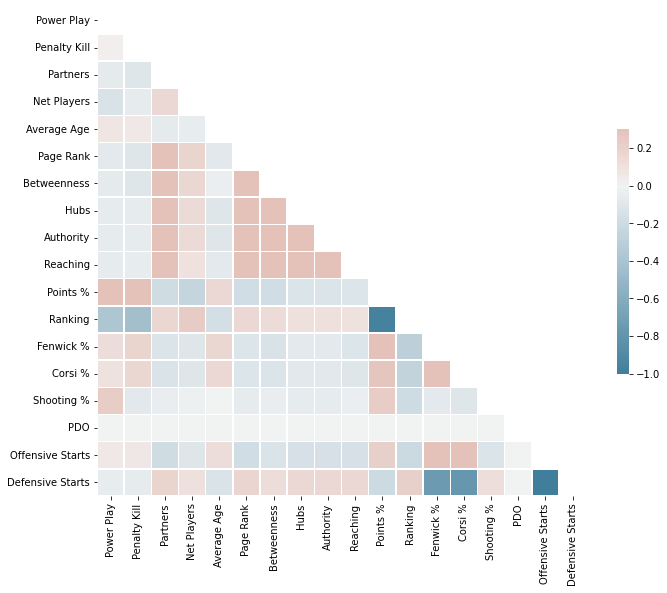

In [65]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#sns.set_theme(style="white")


# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.savefig("corr")

In [ ]:
len(strategies) == len(ranking) == len(pts) == len(num_partners) == len(buyer_seller)

True

In [ ]:
len(winner_partners) == len(winner_regions) == len(winner_strategies)

True

In [ ]:
'''
colors = {
    'National Buyer':,
    'National Seller':,
    'Nationally Balanced':,
    'Regional Buyer':,
    'Regional Seller':,
    'Regionally Balanced':,
    'Local Buyer':,
    'Local Seller':,
    'Locally Balanced':,
    'Unbiased Buyer':,
    'Unbiased Seller':,
    'Balanced':
}

cmaps = [('Perceptually Uniform Sequential', [
            'viridis', 'plasma', 'inferno', 'magma', 'cividis']),
         ('Sequential', [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
         ('Sequential (2)', [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']),
         ('Diverging', [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
         ('Cyclic', ['twilight', 'twilight_shifted', 'hsv']),
         ('Qualitative', [
            'Pastel1', 'Pastel2', 'Paired', 'Accent',
            'Dark2', 'Set1', 'Set2', 'Set3',
            'tab10', 'tab20', 'tab20b', 'tab20c']),
         ('Miscellaneous', [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'turbo', 'nipy_spectral',
            'gist_ncar'])]

'''

"\ncolors = {\n    'National Buyer':,\n    'National Seller':,\n    'Nationally Balanced':,\n    'Regional Buyer':,\n    'Regional Seller':,\n    'Regionally Balanced':,\n    'Local Buyer':,\n    'Local Seller':,\n    'Locally Balanced':,\n    'Unbiased Buyer':,\n    'Unbiased Seller':,\n    'Balanced':\n}\n\ncmaps = [('Perceptually Uniform Sequential', [\n            'viridis', 'plasma', 'inferno', 'magma', 'cividis']),\n         ('Sequential', [\n            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',\n            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',\n            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),\n         ('Sequential (2)', [\n            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',\n            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',\n            'hot', 'afmhot', 'gist_heat', 'copper']),\n         ('Diverging', [\n            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',\n            'RdYlBu', 'RdYl

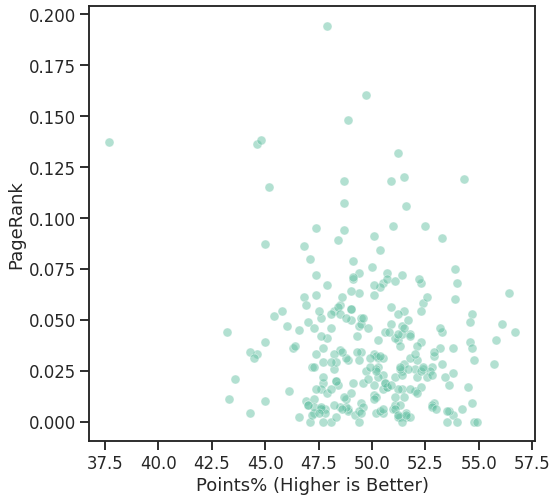

In [72]:
import seaborn as sns

plt.figure(figsize=(8,8))
sns.set_palette("Set2")
sns.scatterplot(x=corsis, y=betweennesses, alpha=.5,y_jitter=40)
plt.xlabel("Points% (Higher is Better)")
plt.ylabel("PageRank")
#plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt.savefig('dpitest.png')

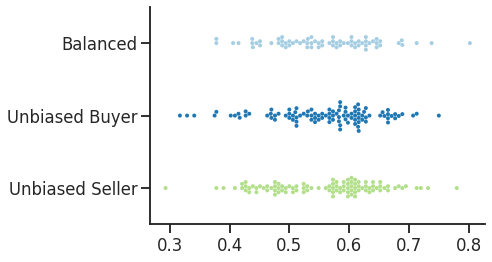

In [69]:
sns.set(style='ticks', context='talk')
#iris = sns.load_dataset('iris')
#plt.xticks(rotation = 45)

sns.set_palette("viridis")
sns.swarmplot(x=pts, y=sorted(strategies), palette='Paired', size=4)
sns.despine()
plt.savefig("scatter")

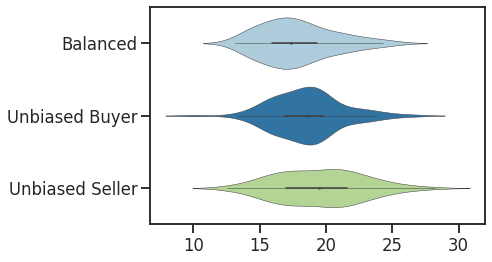

In [70]:
sns.violinplot(x=pps, y=sorted(strategies), linewidth=0.5, palette='Paired')

In [ ]:
strategies

In [ ]:
page_ranks[3]

0.043

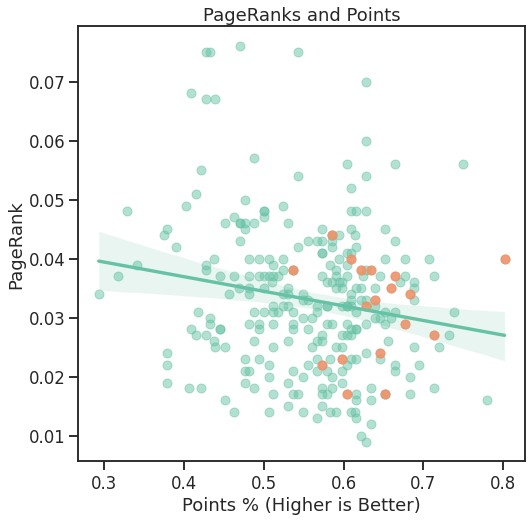

In [80]:
import seaborn as sns

plt.figure(figsize=(8,8))
sns.set_palette("Set2")
sns.regplot(x=pts, y=page_ranks, scatter_kws={'alpha':0.5})
sns.regplot(x=winner_pts, y=winner_page_ranks, fit_reg=False, scatter_kws={'alpha':0.8})
plt.xlabel("Points % (Higher is Better)")
plt.ylabel("PageRank")
plt.title("PageRanks and Points")
#plt.xlim(0, 31)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("pr.png")

In [ ]:
strategy_ex = ['Balanced', 'National Buyer', 'National Seller','Nationally Balanced', 'Regional Buyer',
               'Regional Seller', 'Regionally Balanced', 'Unbiased Buyer', 'Unbiased Seller']
league_total = len(strategies)
champ_total = len(winner_strategies)
expected = []
for s in strategy_ex:
  expected.append(np.round((strategies.count(s)/league_total)*champ_total,1))

actual = []
for s in strategy_ex:
  actual.append(winner_strategies.count(s))

In [ ]:
expected

[2.1, 3.9, 4.3, 1.7, 1.3, 0.9, 0.4, 1.0, 1.5]

In [ ]:
actual

[4, 2, 6, 0, 0, 1, 1, 1, 2]

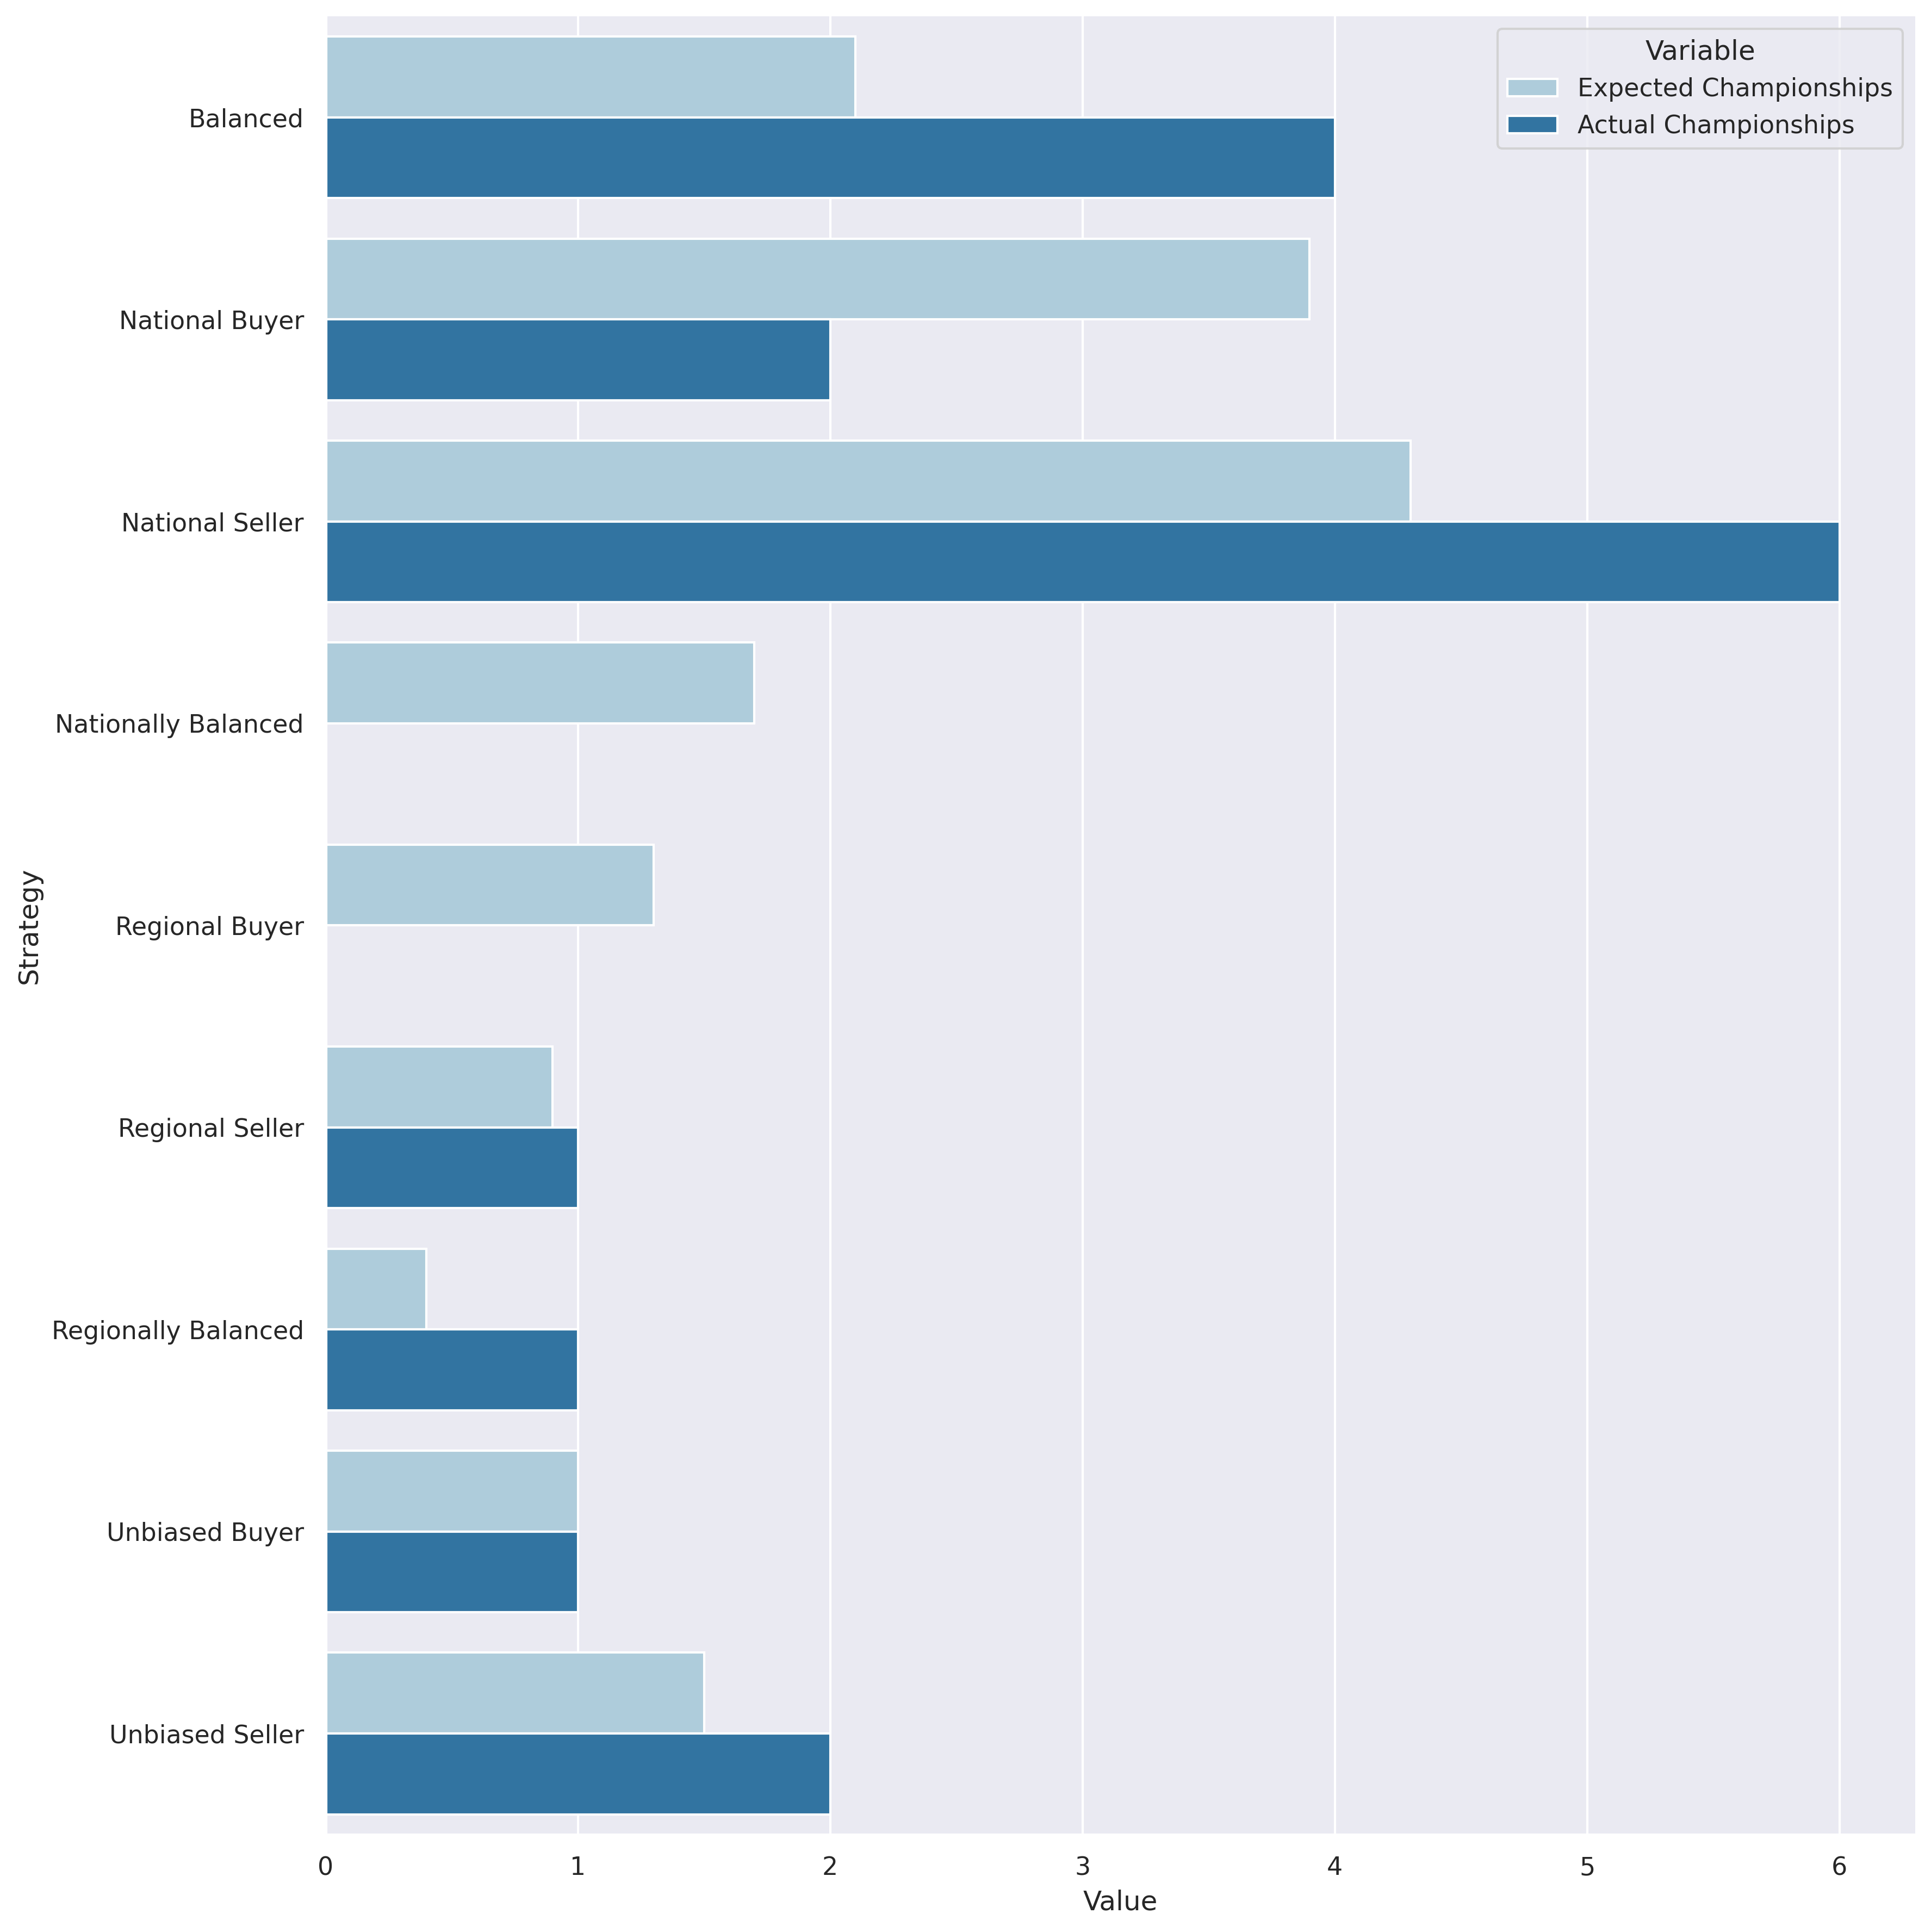

In [ ]:
import seaborn as sns

df = pd.DataFrame({
    'Strategy': strategy_ex,
    'Expected Championships': expected,
    'Actual Championships': actual
})
fig, ax1 = plt.subplots(figsize=(12, 12))
sns.set(font_scale=1)
#plt.figure(figsize=(8,8))
tidy = df.melt(id_vars='Strategy').rename(columns=str.title)
sns.set_palette("Paired")
sns.barplot(x='Value', y='Strategy', hue='Variable', data=tidy, ax=ax1, orient='horizontal')
sns.despine(fig)
plt.tight_layout()
plt.savefig("expected")

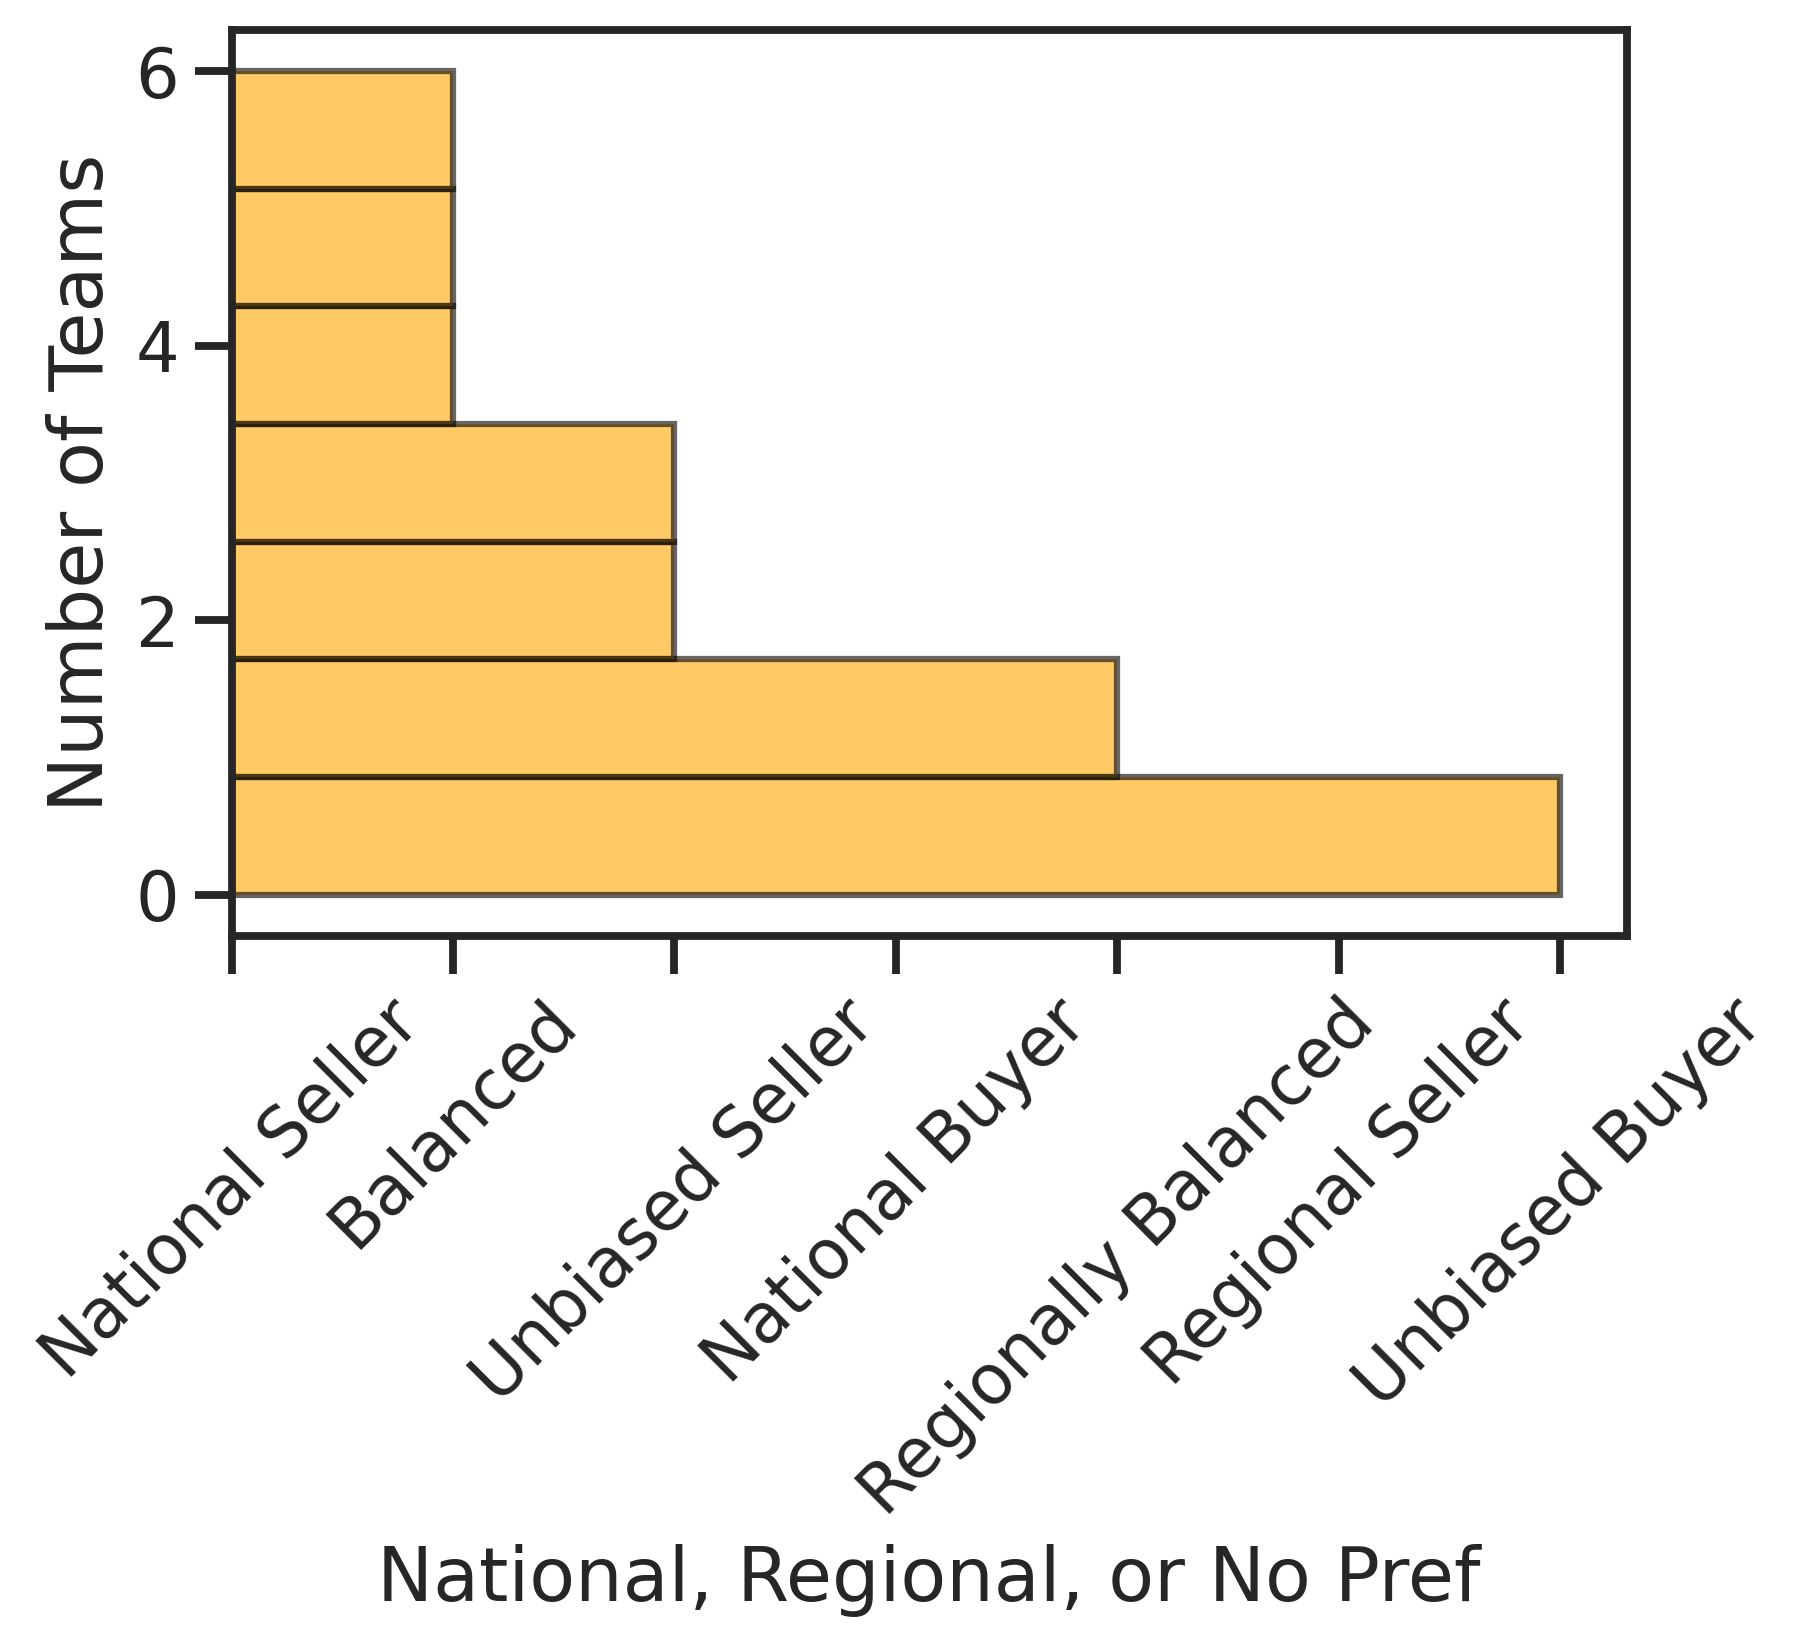

In [ ]:
#plt.figure(figsize=(8,8))
plt.xticks(rotation = 45)
plt.ylabel('Number of Teams')
plt.xlabel('National, Regional, or No Pref')
plt.hist(winner_strategies, edgecolor='black', bins=7, color='orange', alpha=.6, orientation='horizontal')
plt.savefig('test2.png')

In [ ]:
sns.countplot(y=sorted(winner_strategies), palette='Paired', kwarg
plt.savefig("winner")

NameError: ignored

In [ ]:
winner_strategies

['National Seller',
 'Balanced',
 'Unbiased Seller',
 'Balanced',
 'National Seller',
 'National Seller',
 'National Buyer',
 'National Seller',
 'National Seller',
 'Regionally Balanced',
 'Balanced',
 'Unbiased Seller',
 'Regional Seller',
 'Unbiased Buyer',
 'National Seller',
 'National Buyer',
 'Balanced']

ValueError: ignored

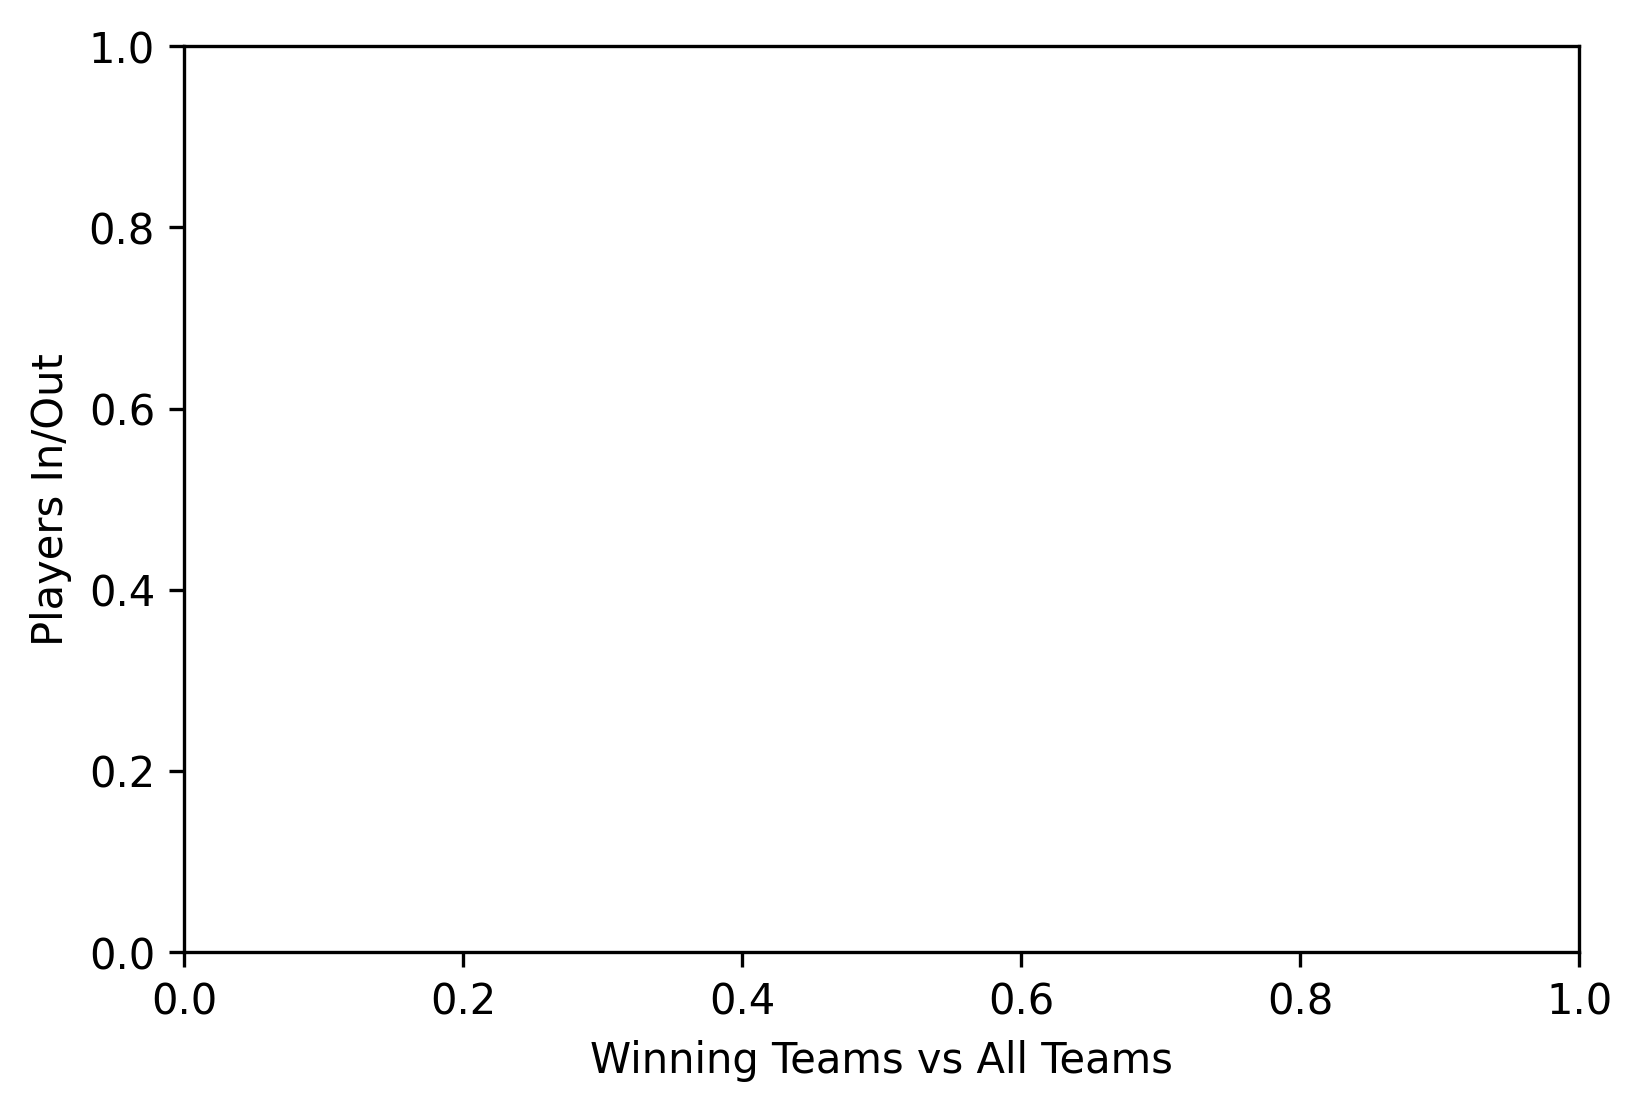

In [ ]:
import seaborn as sns, matplotlib.pyplot as plt, operator as op

plot_data = {
  'All Teams': players,
  'Champions': winner_players
}

# sort keys and values together
sorted_keys, sorted_vals = zip(*sorted(plot_data.items(), key=op.itemgetter(1)))

#plt.figure(figsize=(3,3))
plt.ylabel('Players In/Out')
plt.xlabel('Winning Teams vs All Teams')
sns.boxplot(
    data=sorted_vals,
    #width=.18,
    #edgecolor='black',
    palette=[sns.xkcd_rgb["light orange"], sns.xkcd_rgb["sky blue"]],
    showmeans=True,
    fliersize=3
)
#sns.swarmplot(data=sorted_vals, size=6, edgecolor="black", linewidth=.9)

plt.xticks(plt.xticks()[0], sorted_keys)

plt.savefig("pageranks")

In [ ]:
networks_by_year['2009 - 2010'].nodes['Flames']

{'authority': 0.057,
 'betweenness': 0.068,
 'color_group': 5,
 'conference': 'West',
 'dc': 4,
 'degree': 9.0,
 'division': 'Northwest',
 'favorite_partner': 'MapleLeafs',
 'favorite_partner_weight': 2,
 'hub': 0.057,
 'local_reaching': 0.655,
 'neighbor_degree': 7.556,
 'net_players': 2,
 'page_rank': 0.046,
 'scdd': 6,
 'scsd': 1,
 'strategy': 'Regional Buyer'}

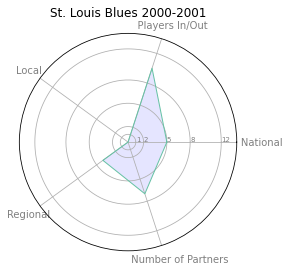

In [ ]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
bruins = networks_by_year['2000 - 2001'].nodes['Blues']
different_conference = bruins['dc']
same_c_diff_d = bruins['scdd']
same_c_same_d = bruins['scsd']
net_players = bruins['net_players']
partners = bruins['degree']

# Set data
df = pd.DataFrame({
'group': ['A'],
'       National': [different_conference],
'    Players In/Out': [abs(net_players)],
'Local': [same_c_same_d],
'Regional': [same_c_diff_d],
'         Number of Partners': [partners]
})
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

#plt.figure(figsize=(4,4))

# Initialise the spider plot
ax = plt.subplot(111, polar=True)


# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=10)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([1,2,5,8,12], ['1','2','5','8','12'], color="grey", size=7)
plt.ylim(0,14)
plt.title("St. Louis Blues 2000-2001")
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.1)

plt.savefig('test2.png', format='png')
# Show the graph
plt.show()



In [ ]:
from itertools import combinations
from scipy.stats import ttest_ind

winners = [winner_hubs, winner_page_ranks, winner_bts, winner_partners, winner_players, winner_reaching, winner_pks, winner_pps, winner_authority]
not_winners = [hubs, page_ranks, betweennesses, num_partners, players, reaching, pks, pps, authority]

for i in range(9):
  t, p = ttest_ind(winners[i], not_winners[i])
  print(f"p-value is {p}")

p-value is 0.3586324905782793
p-value is 0.21641727893533627
p-value is 0.3371185779270387
p-value is 0.12333970243883295
p-value is 0.0787325472515466
p-value is 0.10294918148351921
p-value is 0.13583411986735253
p-value is 0.01713743559843952
p-value is 0.3586324905782793
